In [1]:
attn_dir = "/home/jupyter/save/attn_weights/"

In [325]:
fig_dir = '/home/jupyter/save/figures'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!ls /home/jupyter/save/attn_weights/*all*

/home/jupyter/save/attn_weights/unimodal_bert-all_stats.npz
/home/jupyter/save/attn_weights/visual_bert_coco-all_stats.npz
/home/jupyter/save/attn_weights/visual_bert_direct-all_stats.npz


In [493]:
model = 'visual_bert_coco'
data = np.load('%s/%s-all_stats.npz' % (attn_dir, model))
data.allow_pickle = True

In [264]:
correct = data['correct']
t2v = data['t2v_mass']
v2t = data['v2t_mass']
text = data['text_mass']
vis = data['vis_mass']
text_len = data['lengths']
total_cross = (t2v / text_len[:,None] + v2t / 100) / 2

In [494]:
correct2 = data['correct']
t2v2 = data['t2v_mass']
v2t2 = data['v2t_mass']
text2 = data['text_mass']
vis2 = data['vis_mass']
total_cross2 = (t2v2 / text_len[:,None] + v2t2 / 100) / 2

### Error bar plots by layer

In [272]:
models = ['visual_bert_direct', 'visual_bert_coco', 'unimodal_bert']
vb_models = ['visual_bert_direct', 'visual_bert_coco']

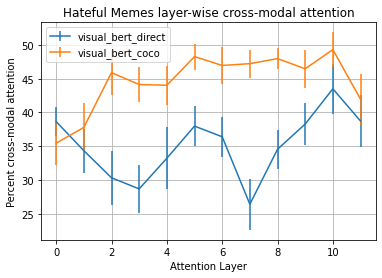

In [335]:
for model, data in zip(vb_models, [total_cross, total_cross2]):
    data = data * 100
    mean = data.mean(axis=0)
    error = np.sqrt(((data - mean[None]) ** 2).sum(axis=0) / (data.shape[0] - 1))
    plt.errorbar(range(12), mean, error, label=model)

plt.legend()
plt.title('Hateful Memes layer-wise cross-modal attention')
plt.ylabel('Percent cross-modal attention')
plt.xlabel('Attention Layer')
plt.grid()
plt.savefig('%s/cross-attn.pdf' % fig_dir)

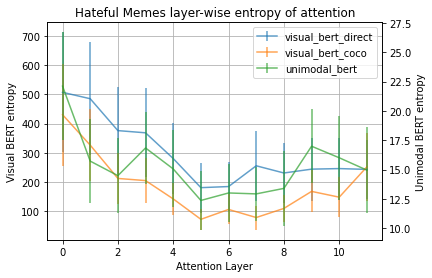

In [334]:
# Entropy
metric = 'entropy'
ax = plt.axes()
ax2 = ax.twinx()
lns = []
colors = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for model in models:
    data = np.load('%s/%s-all_stats.npz' % (attn_dir, model))
    data.allow_pickle = True
    data = -data[metric]
    mean = data.mean(axis=0)
    error = np.sqrt(((data - mean[None]) ** 2).sum(axis=0) / (data.shape[0] - 1))
    if 'unimodal' in model:
        lns += [ax2.errorbar(range(12), mean, error, label=model, color=next(colors), alpha=0.7)]
    else:
        lns += [ax.errorbar(range(12), mean, error, label=model, color=next(colors), alpha=0.7)]
plt.legend(lns, map(lambda x: x.get_label(), lns))
ax.set_ylabel('Visual BERT entropy')
ax2.set_ylabel('Unimodal BERT entropy')
ax.set_xlabel('Attention Layer')
ax.grid()
plt.title('Hateful Memes layer-wise entropy of attention')
plt.savefig('%s/plot-entropy.pdf' % fig_dir)

In [220]:
print(data_files[0]['text_mass'][0,:],
data_files[1]['text_mass'][0,:])

[20.783178 28.236969 42.07475  49.338863 55.606785 83.50806  83.05705
 66.73663  68.13499  70.97402  75.90486  71.38079 ] [ 39.72337   59.054623  83.67201   80.98587   86.59586   98.51502
  91.78892   99.50659  103.38599   76.23467   86.67847   71.98666 ]


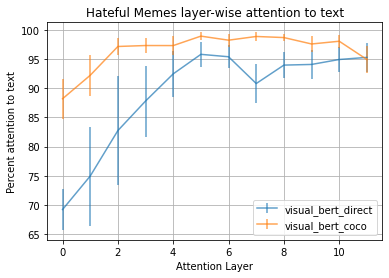

In [490]:
# Visual vs text attention
metrics = ['text_mass', 'vis_mass']
lnstyls = ['-', '--']
data_files = [np.load('%s/%s-all_stats.npz' % (attn_dir, model)) for model in vb_models]
for f in data_files:
    f.allow_pickle = True
data_files = [{
    'text_mass': f['text_mass'],
    'vis_mass': f['vis_mass'],
    'lengths': f['lengths']
} for f in data_files]

colors = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for model, data_ in zip(vb_models, data_files):
    #print(model)
    #data_ = np.load('%s/%s-all_stats.npz' % (attn_dir, model))
    #print(data_['text_mass'][0, :])
    text = data_['text_mass']
    #print(text.mean(axis=0))
    vis = data_['vis_mass']
    #print(vis.mean(axis=0))
    lengths = data_['lengths']
    percent_text = (text / lengths[:,None]) / (vis / 100 + text / lengths[:,None]) * 100
    
    mean = percent_text.mean(axis=0)
    error = np.sqrt(((percent_text - mean[None]) ** 2).sum(axis=0) / (percent_text.shape[0] - 1))

    plt.errorbar(range(12), mean, error, label=model, color=next(colors), alpha=0.7)
    
plt.legend()
plt.ylabel('Percent attention to text')
plt.xlabel('Attention Layer')
plt.grid()
plt.title('Hateful Memes layer-wise attention to text')
plt.savefig('%s/perc-text-attn-norm.pdf' % fig_dir)

### Plot by correctness of classification

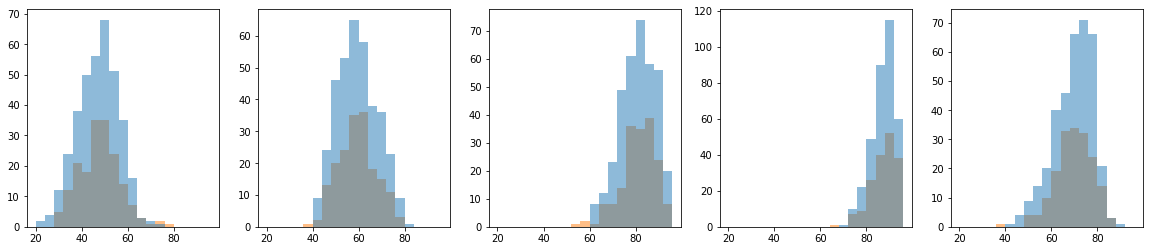

In [56]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, plot_layer in enumerate([0, 1, 2, 6, 11]):
    _ = ax[i].hist([total_cross[:,plot_layer][correct], total_cross[:,plot_layer][~correct]], bins=np.arange(20, 100, 4), histtype='stepfilled', alpha=0.5)

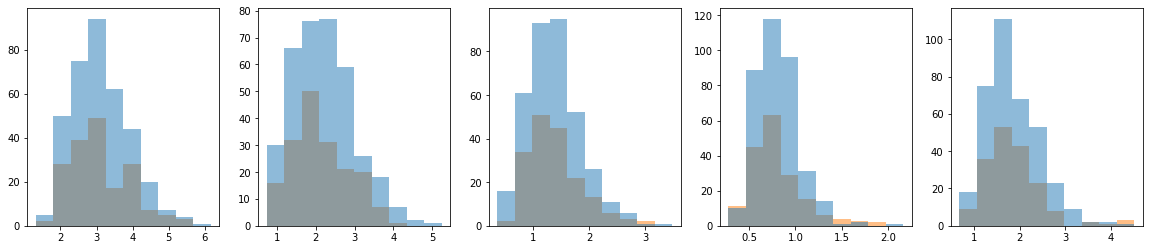

In [58]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, plot_layer in enumerate([0, 1, 2, 6, 11]):
    _ = ax[i].hist([t2v[:,plot_layer][correct], t2v[:,plot_layer][~correct]], histtype='stepfilled', alpha=0.5)

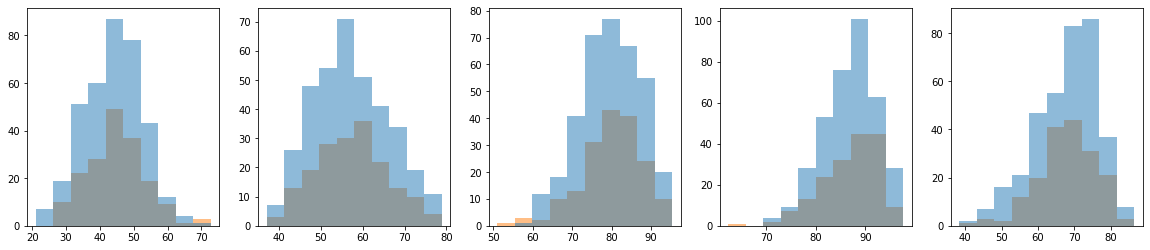

In [59]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, plot_layer in enumerate([0, 1, 2, 6, 11]):
    _ = ax[i].hist([v2t[:,plot_layer][correct], v2t[:,plot_layer][~correct]], histtype='stepfilled', alpha=0.5)

### Plot by improvement over unimodal performance

In [495]:
model = 'unimodal_bert'
data = np.load('%s/%s-all_stats.npz' % (attn_dir, model))
data.allow_pickle = True
correct_uni = data['correct']

In [496]:
model = 'visual_bert_direct'
data = np.load('%s/%s-all_stats.npz' % (attn_dir, model))
data.allow_pickle = True
correct = data['correct']

In [497]:
model = 'visual_bert_coco'
data = np.load('%s/%s-all_stats.npz' % (attn_dir, model))
data.allow_pickle = True
correct2 = data['correct']

In [498]:
improved = np.logical_and(~correct_uni, correct)
improved2 = np.logical_and(~correct_uni, correct2)

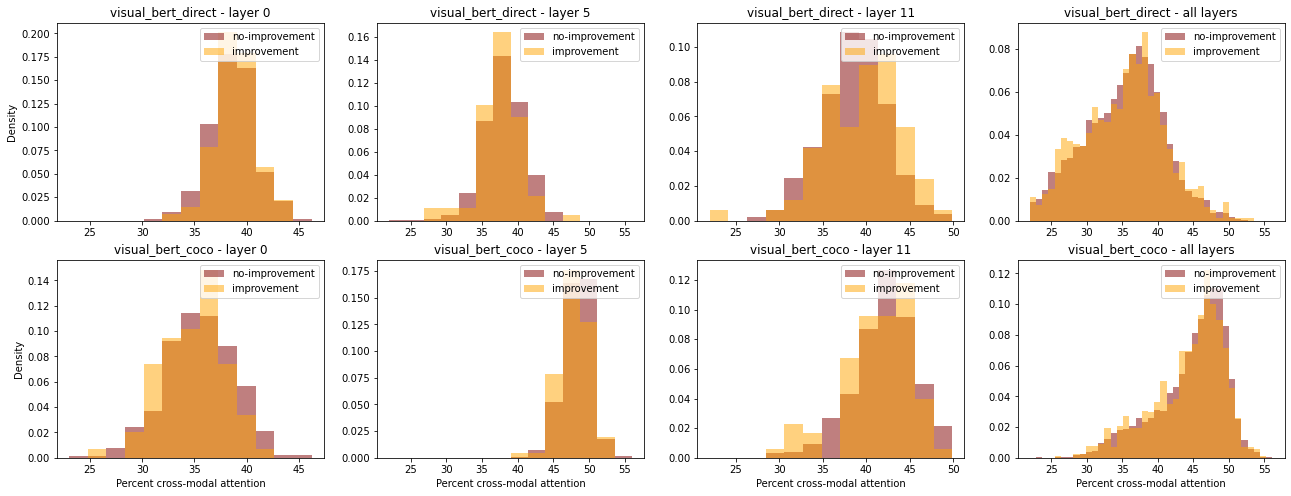

In [450]:
fig, ax = plt.subplots(2, 4, figsize=(22, 8))
stats = [total_cross, total_cross2]
masks = [improved, improved2]
nbins = 14
nbins_final = 40

bins = [np.arange(23, 48, (48 - 23) / nbins), np.arange(22, 56, (56 - 22) / nbins), np.arange(22, 52, (52 - 22) / nbins), np.arange(22, 57, (57 - 22) / nbins_final)]

for j, (model, stat, mask) in enumerate(zip(vb_models, stats, masks)):

    """
    if j == 0:
        bins = []
    else:
        nbins = 14"""
    
    nbins = 14
    
    for i, plot_layer in enumerate([0, 5, 11, None]):
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors = iter(['orange', 'maroon'])

        if plot_layer is None:
            plot_layer = slice(None)
        data = stat[:,plot_layer] * 100
        
        """
        if j == 1:
            nbins = nbins #bins[i]"""
        if i == 3:
            nbins = nbins_final
        
        if j < 2:
            nbins = bins[i]
        
        _, bins_, _ = ax[j, i].hist([data[mask].flatten(), data[~mask].flatten()], histtype='stepfilled', alpha=0.5,
                       label=['improvement', 'no-improvement'], density=True, bins=nbins, color=[next(colors), next(colors)])
        if j == 0:
            bins += [bins_]
        ax[j, i].legend()
        title = model
        if i < 3:
            title += ' - layer %d' % plot_layer
        else:
            title += ' - all layers'
        ax[j, i].set_title(title)
        if j == 1:
            ax[j, i].set_xlabel('Percent cross-modal attention')
    ax[j, 0].set_ylabel('Density')
plt.savefig('%s/cross-modal-hist.pdf' % fig_dir)

### T test (direct)

In [451]:
data = total_cross
X1, X2 = data[improved].mean(), data[~improved].mean()
N1, N2 = len(data[improved].flatten()), len(data[~improved].flatten())
s1 = np.sqrt(((data[improved] - X1) ** 2).sum() / (N1 - 1))
s2 = np.sqrt(((data[~improved] - X2) ** 2).sum() / (N2 - 1))


In [452]:
t = (X1 - X2) / np.sqrt(s1**2/N1 + s2**2/N2)

In [453]:
freedom = (s1**2/N1 + s2**2/N2)**2 / (s1**4/(N1**2 *(N1-1)) + s2**4/(N2**2 * (N2-1)))

In [454]:
freedom, t # p-value of 0.45835 (fail to reject)

(1252.9219562954504, 0.10460190905129511)

In [455]:
import scipy.stats as stats

In [456]:
pval = stats.t.sf(np.abs(t), freedom)

In [457]:
pval

0.45835422080593935

In [491]:
0.45835422080593935 * 2

0.9167084416118787

### T test (coco)

In [499]:
data = total_cross2
X1, X2 = data[improved2].mean(), data[~improved2].mean()
N1, N2 = len(data[improved2].flatten()), len(data[~improved2].flatten())
s1 = np.sqrt(((data[improved2] - X1) ** 2).sum() / (N1 - 1))
s2 = np.sqrt(((data[~improved2] - X2) ** 2).sum() / (N2 - 1))


In [500]:
t = (X1 - X2) / np.sqrt(s1**2/N1 + s2**2/N2)

In [501]:
freedom = (s1**2/N1 + s2**2/N2)**2 / (s1**4/(N1**2 *(N1-1)) + s2**4/(N2**2 * (N2-1)))

In [502]:
freedom, t # p-value of 0.014939 (reject)

(1387.4520814875234, -2.1739338520617983)

In [462]:
import scipy.stats as stats

In [463]:
pval = stats.t.sf(np.abs(t), freedom)

In [464]:
pval

0.014939345771135972

In [492]:
0.014939345771135972 * 2

0.029878691542271945

### Investigate separately samples where vb-coco/vb-direct outperformed

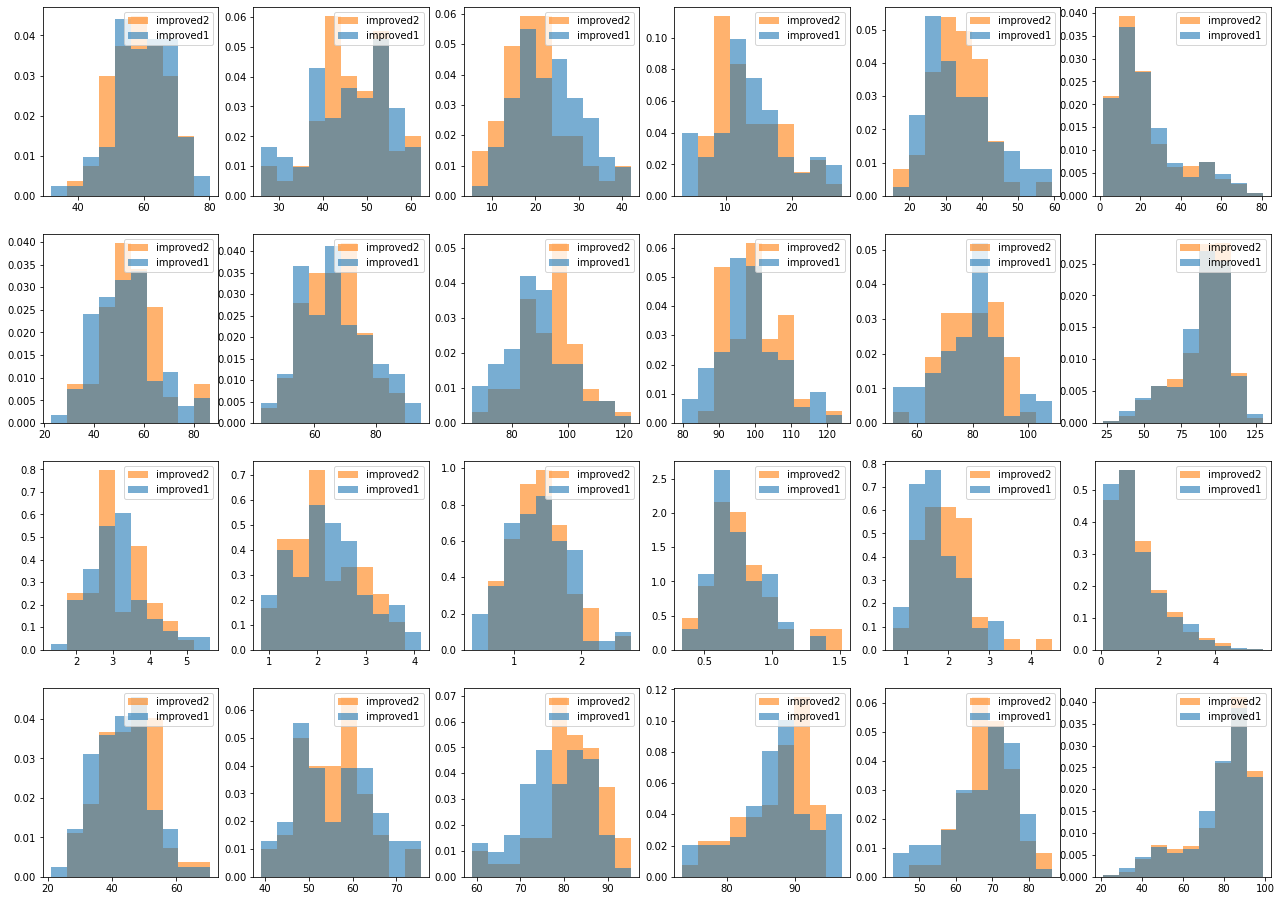

In [62]:
fig, ax = plt.subplots(4, 6, figsize=(22, 16))
stats = [vis, text, t2v, v2t]
for j, stat in enumerate(stats):
    for i, plot_layer in enumerate([0, 1, 2, 6, 11, None]):
        if plot_layer is None:
            plot_layer = slice(None)
        _ = ax[j, i].hist([stat[:,plot_layer][improved1].flatten(), stat[:,plot_layer][improved2].flatten()], histtype='stepfilled', alpha=0.6,
                       label=['improved1', 'improved2'], density=True)
        ax[j, i].legend()

### Can entropy in unimodal bert attentions predict performance?

In [474]:
model = 'unimodal_bert'
data = np.load('%s/%s-all_stats.npz' % (attn_dir, model))
data.allow_pickle = True
correct = data['correct']
entropy = -data['entropy']

In [475]:
model = 'visual_bert_direct'
data = np.load('%s/%s-all_stats.npz' % (attn_dir, model))
data.allow_pickle = True
correct2 = data['correct']
entropy2 = -data['entropy']

In [476]:
model = 'visual_bert_coco'
data = np.load('%s/%s-all_stats.npz' % (attn_dir, model))
data.allow_pickle = True
correct3 = data['correct']
entropy3 = -data['entropy']

In [289]:
_

(array([[3.70265167e-03, 3.43884951e-03, 1.55219303e-03, 8.47935496e-04,
         3.55661833e-04, 1.67231723e-04, 8.24381733e-05, 4.23967748e-05,
         3.29752693e-05, 4.71075276e-06, 2.35537638e-06, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 2.35537638e-06],
        [3.69799384e-03, 3.32915249e-03, 1.70529250e-03, 7.76003890e-04,
         3.40100470e-04, 2.15556636e-04, 7.18522120e-05, 4.79014747e-05,
         3.83211797e-05, 9.58029493e-06, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 array([  18.29859534,  116.03353924,  213.76848315,  311.50342705,
         409.23837096,  506.97331486,  604.70825877,  702.44320267,
         800.17814658,  897.91309048,  995.64803438, 1093.38297829,
        1191.11792219, 1288.8528661 , 1386.58781   , 1484.32275391]),
 <a list of 2 List[Polygon] objects>)

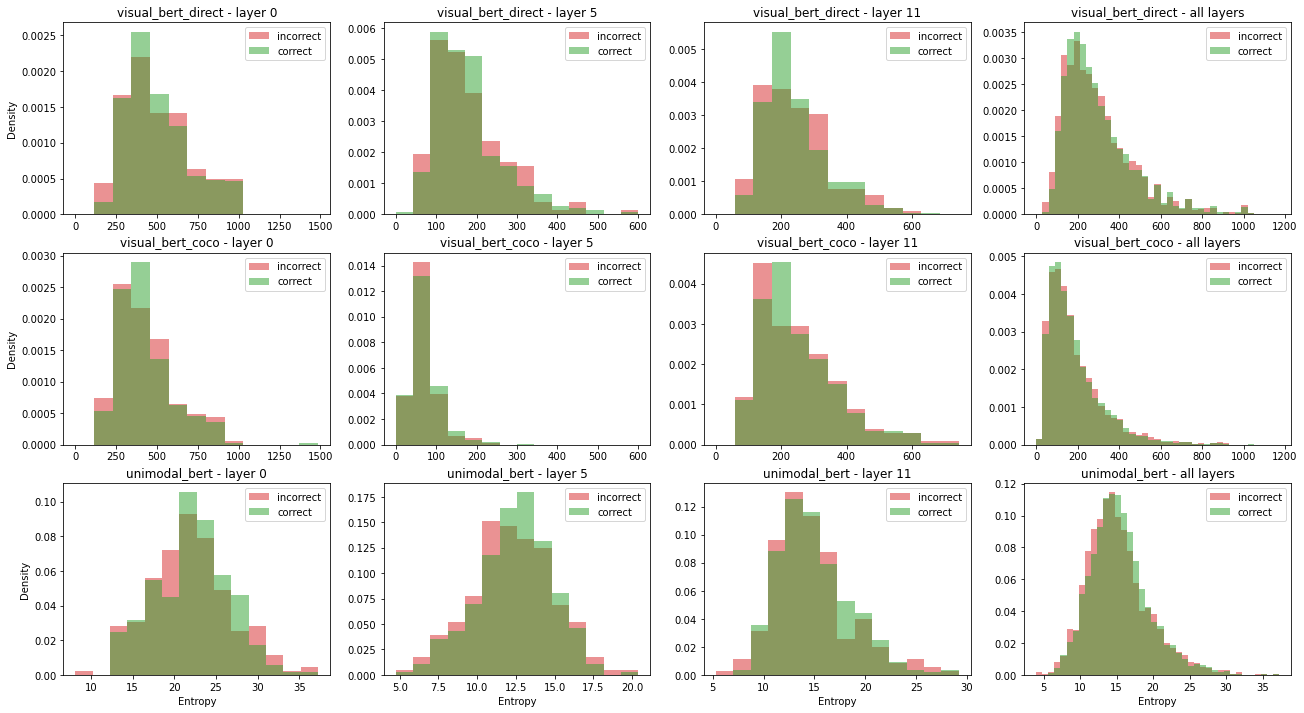

In [441]:
fig, ax = plt.subplots(3, 4, figsize=(22, 12))
stats = [entropy2, entropy3, entropy]
masks = [correct2, correct3, correct]
nbins = 14
nbins_final = 40

bins = [np.arange(0, 1600, 1600 / nbins), np.arange(0, 600, 600 / nbins), np.arange(0, 800, 800 / nbins), np.arange(0, 1200, 1200 / nbins_final)]

for j, (model, stat, mask) in enumerate(zip(models, stats, masks)):

    """
    if j == 0:
        bins = []
    else:
        nbins = 14"""
    nbins = 14
    
    for i, plot_layer in enumerate([0, 5, 11, None]):
        colors = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][2:])

        if plot_layer is None:
            plot_layer = slice(None)
        data = stat[:,plot_layer]
        """
        if j == 1:
            nbins = bins[i]
        elif i == 3:
            nbins = nbins_final"""
        
        if i == 3:
            nbins = nbins_final
        if j < 2:
            nbins = bins[i]
        
        _, bins_, _ = ax[j, i].hist([data[mask].flatten(), data[~mask].flatten()], histtype='stepfilled', alpha=0.5,
                       label=['correct', 'incorrect'], density=True, bins=nbins, color=[next(colors), next(colors)])
        if j == 0:
            bins += [bins_]
        ax[j, i].legend()
        title = model
        if i < 3:
            title += ' - layer %d' % plot_layer
        else:
            title += ' - all layers'
        ax[j, i].set_title(title)
        if j == 2:
            ax[j, i].set_xlabel('Entropy')
    ax[j, 0].set_ylabel('Density')
plt.savefig('%s/entropy-hist.pdf' % fig_dir)

In [284]:
data.max()

1484.32275390625

### T test (unimodal bert)

In [477]:
X1, X2 = entropy[correct].mean(), entropy[~correct].mean()
N1, N2 = len(entropy[correct].flatten()), len(entropy[~correct].flatten())
s1 = np.sqrt(((entropy[correct] - X1) ** 2).sum() / (N1 - 1))
s2 = np.sqrt(((entropy[~correct] - X2) ** 2).sum() / (N2 - 1))


In [478]:
t = (X1 - X2) / np.sqrt(s1**2/N1 + s2**2/N2)

In [479]:
freedom = (s1**2/N1 + s2**2/N2)**2 / (s1**4/(N1**2 *(N1-1)) + s2**4/(N2**2 * (N2-1)))

In [480]:
freedom, t # p-value of 0.014889 (reject)

(5039.659638054228, 2.173651663693178)

In [481]:
import scipy.stats as stats

In [482]:
pval = stats.t.sf(np.abs(t), freedom)

In [483]:
pval

0.01488885388091962

In [485]:
0.01488885388091962 * 2

0.02977770776183924

### T test (visual bert direct)

In [133]:
X1, X2 = entropy2[correct2].mean(), entropy2[~correct2].mean()
N1, N2 = len(entropy2[correct2].flatten()), len(entropy2[~correct2].flatten())
s1 = np.sqrt(((entropy2[correct2] - X1) ** 2).sum() / (N1 - 1))
s2 = np.sqrt(((entropy2[~correct2] - X2) ** 2).sum() / (N2 - 1))

In [134]:
t = (X1 - X2) / np.sqrt(s1**2/N1 + s2**2/N2)

In [135]:
freedom = (s1**2/N1 + s2**2/N2)**2 / (s1**4/(N1**2 *(N1-1)) + s2**4/(N2**2 * (N2-1)))

In [136]:
freedom, t # p-value of 0.17455 (fail to reject)

(4266.068546201074, 0.9364335487232239)

In [137]:
import scipy.stats as stats

In [138]:
pval = stats.t.sf(np.abs(t), freedom)

In [139]:
pval

0.17455150900962318

In [466]:
0.17455150900962318 * 2

0.34910301801924637

### T test (visual bert coco)

In [140]:
X1, X2 = entropy3[correct3].mean(), entropy3[~correct3].mean()
N1, N2 = len(entropy3[correct3].flatten()), len(entropy3[~correct3].flatten())
s1 = np.sqrt(((entropy3[correct3] - X1) ** 2).sum() / (N1 - 1))
s2 = np.sqrt(((entropy3[~correct3] - X2) ** 2).sum() / (N2 - 1))

In [141]:
t = (X1 - X2) / np.sqrt(s1**2/N1 + s2**2/N2)

In [142]:
freedom = (s1**2/N1 + s2**2/N2)**2 / (s1**4/(N1**2 *(N1-1)) + s2**4/(N2**2 * (N2-1)))

In [143]:
freedom, t # p-value of 0.466359 (fail to reject)

(4192.74847410432, -0.08443083144098698)

In [144]:
import scipy.stats as stats

In [145]:
pval = stats.t.sf(np.abs(t), freedom)

In [146]:
pval

0.46635896289474826

In [465]:
0.46635896289474826 * 2

0.9327179257894965